# LSTM Stock Predictor Using Closing Prices

### Data Preparation

### In this section, we will prepare the training and testing data for the LSTM model.

### We will need to:
    1. Use window_data function to generate X and y values for the model.
    2. Split the data into 70% training and 30% testing
    3. Apply the MinMaxScaler to the X and y values
    4. Reshape the X_train and X_test data for the model.
    
### **Note**: The required input format for the LSTM is:

            reshape((X_train.shape[0], X_train.shape[1], 1))    

In [156]:
# Initial imports
import numpy as np
import pandas as pd
from pathlib import Path
import yfinance as yf
%matplotlib inline

In [157]:
# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

### Data Loading

In this activity, we will use closing prices from different stocks to make predictions of future closing prices based on the temporal data of each stock.

In [158]:
# Historical Carnival Cruise Stock Price:
# OHLCV using yfinance
# Load the stocks data
ccl = yf.download("CCL", start="2010-01-01", end="2021-01-21", 
    index_col="Date", infer_datetime_format=True, parse_dates=True)
ccl.dropna(inplace=True)
#ccl.head()

[*********************100%***********************]  1 of 1 completed


In [159]:
# Historical Delta Airlines Stock Price:
# OHLCV using yfinance
# Load the stocks data
dal = yf.download("DAL", start="2010-01-01", end="2021-01-21", 
    index_col="Date", infer_datetime_format=True, parse_dates=True)
dal.dropna(inplace=True)
#dal.head()

[*********************100%***********************]  1 of 1 completed


In [160]:
# Historical ETSY Stock Price:
# OHLCV using yfinance
# Load the stocks data
etsy = yf.download("ETSY", start="2010-01-01", end="2021-01-21", 
    index_col="Date", infer_datetime_format=True, parse_dates=True)
etsy.dropna(inplace=True)
#etsy.head()

[*********************100%***********************]  1 of 1 completed


In [161]:
# Historical L Brands Stock Price:
# OHLCV using yfinance
# Load the stocks data
LB = yf.download("LB", start="2010-01-01", end="2021-01-21", 
    index_col="Date", infer_datetime_format=True, parse_dates=True)
LB.dropna(inplace=True)
#LB.head()

[*********************100%***********************]  1 of 1 completed


In [162]:
# Historical SPY Stock Price:
# OHLCV using yfinance
# Load the stocks data
spy = yf.download("SPY", start="2010-01-01", end="2021-01-21", 
    index_col="Date", infer_datetime_format=True, parse_dates=True)
spy.dropna(inplace=True)
#spy.head()

[*********************100%***********************]  1 of 1 completed


In [163]:
ccl_df = ccl[['Close']].copy()
dal_df = dal[['Close']].copy()
etsy_df = etsy[['Close']].copy()
LB_df = LB[['Close']].copy()
spy_df = spy[['Close']].copy()

In [164]:
ccl_df.rename(columns = {'Close':'CCL'}, inplace = True) 
dal_df.rename(columns = {'Close':'DAL'}, inplace = True) 
etsy_df.rename(columns = {'Close':'ETSY'}, inplace = True) 
LB_df.rename(columns = {'Close':'LB'}, inplace = True) 
spy_df.rename(columns = {'Close':'SPY'}, inplace = True) 
#spy_df.head()

In [165]:
dfs = [ccl_df, dal_df, etsy_df, LB_df,spy_df ]
df = pd.concat(dfs,axis=1,join="outer",ignore_index=False)
df.tail()

,CCL,DAL,ETSY,LB,SPY
Date,,,,,
2021-01-13,20.100000,40.450001,207.029999,46.160000,379.790009
2021-01-14,20.920000,41.470001,211.520004,44.980000,378.459991
2021-01-15,20.790001,39.980000,204.419998,45.200001,375.700012
2021-01-19,20.870001,40.310001,221.309998,45.730000,378.649994
2021-01-20,20.780001,41.619999,215.690002,45.560001,383.890015


In [166]:
pre_covid_df = df.loc['2010-01-01':'2020-02-20']
covid_df = df.loc['2020-02-21': '2021-01-20']
pre_covid_df.head()

,CCL,DAL,ETSY,LB,SPY
Date,,,,,
2010-01-04,32.060001,11.22,NaN,19.309999,113.330002
2010-01-05,32.369999,12.10,NaN,18.680000,113.629997
2010-01-06,31.790001,12.11,NaN,19.070000,113.709999
2010-01-07,32.139999,12.69,NaN,18.760000,114.190002
2010-01-08,33.220001,12.47,NaN,19.590000,114.570000


### Creating the Features X and Target y Data

The first step towards preparing the data is to create the input features vectors X and the target vector y. We will use the window_data() function to create these vectors.

This function chunks the data up with a rolling window of Xt - window to predict Xt.

The function returns two numpy arrays:

 - X: The input features vectors.

 - y: The target vector.

The function has the following parameters:

 - df: The original DataFrame with the time series data.

 - window: The window size in days of previous closing prices that will be used for the prediction.

 - feature_col_number: The column number from the original DataFrame where the features are located.

 - target_col_number: The column number from the original DataFrame where the target is located.

In [167]:
#creating PRECOVID data function
def window_data_precovid(pre_covid_df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X_precovid = []
    y_precovid = []
    for i in range(len(pre_covid_df) - window):
        features = pre_covid_df.iloc[i : (i + window), feature_col_number]
        target = pre_covid_df.iloc[(i + window), target_col_number]
        X_precovid.append(features)
        y_precovid.append(target)
    return np.array(X_precovid), np.array(y_precovid).reshape(-1, 1)

In [168]:
#creating COVID data function
def window_data_covid(covid_df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X_covid = []
    y_covid = []
    for i in range(len(covid_df) - window):
        features = covid_df.iloc[i : (i + window), feature_col_number]
        target = covid_df.iloc[(i + window), target_col_number]
        X_covid.append(features)
        y_covid.append(target)
    return np.array(X_covid), np.array(y_covid).reshape(-1, 1)

We want to predict closing prices using a 5 days windows of previous closing prices, so that, we will create the X and y vectors by calling the window_data function and defining a window size of 5 and setting the features and target column numbers to (0, 1, 2, 3 )the respective column.

In [195]:
# Creating the features (X) and target (y) data using the window_data_precovid() function.
# PRECOVID
window_size = 5

feature_column = 4
target_column = 4
X_precovid, y_precovid = window_data_precovid(pre_covid_df, window_size, feature_column, target_column)
print (f"X sample values:\n{X_precovid[:5]} \n")
print (f"y sample values:\n{y_precovid[:5]}")

X sample values:
[[113.33000183 113.62999725 113.70999908 114.19000244 114.56999969]
 [113.62999725 113.70999908 114.19000244 114.56999969 114.73000336]
 [113.70999908 114.19000244 114.56999969 114.73000336 113.66000366]
 [114.19000244 114.56999969 114.73000336 113.66000366 114.62000275]
 [114.56999969 114.73000336 113.66000366 114.62000275 114.93000031]] 

y sample values:
[[114.73000336]
 [113.66000366]
 [114.62000275]
 [114.93000031]
 [113.63999939]]


In [196]:
# Creating the features (X) and target (y) data using the window_data_covid() function
# COVID
window_size = 5

feature_column = 4
target_column = 4
X_covid, y_covid = window_data_covid(covid_df, window_size, feature_column, target_column)
print (f"X sample values:\n{X_covid[:5]} \n")
print (f"y sample values:\n{y_covid[:5]}")

X sample values:
[[333.48001099 322.42001343 312.6499939  311.5        297.51000977]
 [322.42001343 312.6499939  311.5        297.51000977 296.26000977]
 [312.6499939  311.5        297.51000977 296.26000977 309.08999634]
 [311.5        297.51000977 296.26000977 309.08999634 300.23999023]
 [297.51000977 296.26000977 309.08999634 300.23999023 312.85998535]] 

y sample values:
[[296.26000977]
 [309.08999634]
 [300.23999023]
 [312.85998535]
 [302.45999146]]


In [197]:
# Creating the features (X) and target (y) data using the window_data_covid() function
# Total_df
window_size = 5

feature_column = 4
target_column = 4
X_df, y_df = window_data_covid(df, window_size, feature_column, target_column)
print (f"X sample values:\n{X_df[:5]} \n")
print (f"y sample values:\n{y_df[:5]}")

X sample values:
[[113.33000183 113.62999725 113.70999908 114.19000244 114.56999969]
 [113.62999725 113.70999908 114.19000244 114.56999969 114.73000336]
 [113.70999908 114.19000244 114.56999969 114.73000336 113.66000366]
 [114.19000244 114.56999969 114.73000336 113.66000366 114.62000275]
 [114.56999969 114.73000336 113.66000366 114.62000275 114.93000031]] 

y sample values:
[[114.73000336]
 [113.66000366]
 [114.62000275]
 [114.93000031]
 [113.63999939]]


### Splitting Data Between Training and Testing Sets
To avoid the dataset being randomized, we will manually split the data using array slicing.

In [198]:
# Use 70% of the data for training and the remainder for testing PRECOVID
split_precovid = int(0.7 * len(X_precovid))
X_train_precovid = X_precovid[: split_precovid]
X_test_precovid = X_precovid[split_precovid:]
y_train_precovid = y_precovid[: split_precovid]
y_test_precovid = y_precovid[split_precovid:]

In [199]:
# Use 70% of the data for training and the remainder for testing COVID
split_covid = int(0.7 * len(X_covid))
X_train_covid = X_covid[: split_covid]
X_test_covid = X_covid[split_covid:]
y_train_covid = y_covid[: split_covid]
y_test_covid = y_covid[split_covid:]

In [200]:
# Use 70% of the data for training and the remainder for testing DF
split_df = int(0.7 * len(X_df))
X_train_df = X_df[: split_df]
X_test_df = X_df[split_df:]
y_train_df = y_df[: split_df]
y_test_df = y_df[split_df:]

### Scaling Data with MinMaxScaler
Once the training and test datasets are created, we need to scale the data before training the LSTM model. We will use the MinMaxScaler from sklearn to scale all values between 0 and 1.

Note that we scale both features and target sets.

In [201]:
# Use the MinMaxScaler to scale data between 0 and 1.
#PRECOVID
from sklearn.preprocessing import MinMaxScaler

scaler_precovid = MinMaxScaler()
scaler_precovid.fit(X_precovid)
X_train_precovid = scaler_precovid.transform(X_train_precovid)
X_test_precovid = scaler_precovid.transform(X_test_precovid)
scaler_precovid.fit(y_precovid)
y_train_precovid = scaler_precovid.transform(y_train_precovid)
y_test_precovid = scaler_precovid.transform(y_test_precovid)

In [202]:
# Use the MinMaxScaler to scale data between 0 and 1.
#COVID
scaler_covid = MinMaxScaler()
scaler_covid.fit(X_covid)
X_train_covid = scaler_covid.transform(X_train_covid)
X_test_covid = scaler_covid.transform(X_test_covid)
scaler_covid.fit(y_covid)
y_train_covid = scaler_covid.transform(y_train_covid)
y_test_covid = scaler_covid.transform(y_test_covid)
X_covid_scaled = scaler_covid.transform(X_covid)

In [203]:
# Use the MinMaxScaler to scale data between 0 and 1.
# DF
scaler_df = MinMaxScaler()
scaler_df.fit(X_df)
X_train_df = scaler_df.transform(X_train_df)
X_test_df = scaler_df.transform(X_test_df)
scaler_df.fit(y_df)
y_train_df = scaler_df.transform(y_train_df)
y_test_df = scaler_df.transform(y_test_df)
X_covid_df = scaler_df.transform(X_df)

### Reshape Features Data for the LSTM Model
The LSTM API from Keras needs to receive the features data as a vertical vector, so that we need to reshape the X data in the form reshape((X_train.shape[0], X_train.shape[1], 1)).

Both sets, training, and testing are reshaped.

In [204]:
# Reshape the features for the model
#PRECOVID
X_train_precovid = X_train_precovid.reshape((X_train_precovid.shape[0], X_train_precovid.shape[1], 1))
X_test_precovid = X_test_precovid.reshape((X_test_precovid.shape[0], X_test_precovid.shape[1], 1))
print (f"X_train sample values:\n{X_train_precovid[:5]} \n")
print (f"X_test sample values:\n{X_test_precovid[:5]}")

X_train sample values:
[[[0.04731742]
  [0.0485928 ]
  [0.0488955 ]
  [0.0509346 ]
  [0.05238419]]

 [[0.0485928 ]
  [0.04893292]
  [0.0509346 ]
  [0.05254886]
  [0.05306177]]

 [[0.04893292]
  [0.05097358]
  [0.05254886]
  [0.05322857]
  [0.04853056]]

 [[0.05097358]
  [0.05258907]
  [0.05322857]
  [0.04868312]
  [0.05259594]]

 [[0.05258907]
  [0.0532693 ]
  [0.04868312]
  [0.05276128]
  [0.05390871]]] 

X_test sample values:
[[[0.53282031]
  [0.53320291]
  [0.53343247]
  [0.54010193]
  [0.53667314]]

 [[0.53320291]
  [0.53384065]
  [0.54010193]
  [0.5383602 ]
  [0.53671553]]

 [[0.53384065]
  [0.54051522]
  [0.5383602 ]
  [0.53840272]
  [0.53798598]]

 [[0.54051522]
  [0.53877216]
  [0.53840272]
  [0.53967716]
  [0.54374528]]

 [[0.53877216]
  [0.53881471]
  [0.53967716]
  [0.54545456]
  [0.54759887]]]


In [176]:
# Reshape the features for the model
# COVID
X_train_covid = X_train_covid.reshape((X_train_covid.shape[0], X_train_covid.shape[1], 1))
X_test_covid = X_test_covid.reshape((X_test_covid.shape[0], X_test_covid.shape[1], 1))
print (f"X_train sample values:\n{X_train_covid[:5]} \n")
print (f"X_test sample values:\n{X_test_covid[:5]}")

X_train sample values:
[[[0.69818713]
  [0.62832423]
  [0.56660975]
  [0.55934556]
  [0.47097471]]

 [[0.62832423]
  [0.56660975]
  [0.55934556]
  [0.47097471]
  [0.46307881]]

 [[0.56660975]
  [0.55934556]
  [0.47097471]
  [0.46307881]
  [0.54412224]]

 [[0.55934556]
  [0.47097471]
  [0.46307881]
  [0.54412224]
  [0.48821923]]

 [[0.47097471]
  [0.46307881]
  [0.54412224]
  [0.48821923]
  [0.56793621]]] 

X_test sample values:
[[[0.70734626]
  [0.74417285]
  [0.76324927]
  [0.78264165]
  [0.81788886]]

 [[0.74417285]
  [0.76324927]
  [0.78264165]
  [0.81788886]
  [0.80336048]]

 [[0.76324927]
  [0.78264165]
  [0.81788886]
  [0.80336048]
  [0.78946362]]

 [[0.78264165]
  [0.81788886]
  [0.80336048]
  [0.78946362]
  [0.78674748]]

 [[0.81788886]
  [0.80336048]
  [0.78946362]
  [0.78674748]
  [0.78542102]]]


In [205]:
# Reshape the features for the model
# COVID
X_train_df = X_train_df.reshape((X_train_df.shape[0], X_train_df.shape[1], 1))
X_test_df = X_test_df.reshape((X_test_df.shape[0], X_test_df.shape[1], 1))
print (f"X_train sample values:\n{X_train_df[:5]} \n")
print (f"X_test sample values:\n{X_test_df[:5]}")

X_train sample values:
[[[0.03988391]
  [0.04095893]
  [0.04124562]
  [0.04296569]
  [0.04432739]]

 [[0.04095893]
  [0.04124562]
  [0.04296569]
  [0.04432739]
  [0.04490076]]

 [[0.04124562]
  [0.04296569]
  [0.04432739]
  [0.04490076]
  [0.04106646]]

 [[0.04296569]
  [0.04432739]
  [0.04490076]
  [0.04106646]
  [0.04450658]]

 [[0.04432739]
  [0.04490076]
  [0.04106646]
  [0.04450658]
  [0.04561744]]] 

X_test sample values:
[[[0.52744928]
  [0.52762846]
  [0.52580086]
  [0.52633842]
  [0.52981437]]

 [[0.52762846]
  [0.52580086]
  [0.52633842]
  [0.52981437]
  [0.53088942]]

 [[0.52580086]
  [0.52633842]
  [0.52981437]
  [0.53088942]
  [0.53404283]]

 [[0.52633842]
  [0.52981437]
  [0.53088942]
  [0.53404283]
  [0.53794884]]

 [[0.52981437]
  [0.53088942]
  [0.53404283]
  [0.53794884]
  [0.53988388]]]


### Build and Train the LSTM RNN
In this section, we will design a custom LSTM RNN in Keras and fit (train) it using the training data we defined.

We will need to:

 1. Define the model architecture in Keras.

 2. Compile the model.

 3. Fit the model to the training data.

#### Importing the Keras Modules
The LSTM RNN model in Keras uses the Sequential model and the LSTM layer as we did before. However, there is a new type of layer called Dropout.

 - Dropout: Dropout is a regularization technique for reducing overfitting in neural networks. This type of layer applies the dropout technique to the input.

In [206]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

### Defining the LSTM RNN Model Structure
To create an LSTM RNN model, we will add LSTM layers. The return_sequences parameter needs to set to True every time we add a new LSTM layer, excluding the final layer. The input_shape is the number of time steps and the number of indicators

After each LSTM layer, we add a Dropout layer to prevent overfitting. The parameter passed to the Dropout layer is the fraction of nodes that will be drop on each epoch, for this demo, we will use a dropout value of 0.2, it means that on each epoch we will randomly drop 20% of the units.

The number of units in each LSTM layers, is equal to the size of the time window, in this demo, we are taking five previous  closing prices to predict the next closing price.

In [207]:
# Define the LSTM RNN model.
#PRECOVID
model_precovid = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model_precovid.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train_precovid.shape[1], 1))
    )
model_precovid.add(Dropout(dropout_fraction))
# Layer 2
model_precovid.add(LSTM(units=number_units, return_sequences=True))
model_precovid.add(Dropout(dropout_fraction))
# Layer 3
model_precovid.add(LSTM(units=number_units))#, return_sequences=True))
model_precovid.add(Dropout(dropout_fraction))

# Layer 4
#model.add(LSTM(units=number_units))
#model.add(Dropout(dropout_fraction))





# Output layer
model_precovid.add(Dense(1))

In [179]:
# Define the LSTM RNN model.
#PRECOVID
model_covid = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model_covid.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train_covid.shape[1], 1))
    )
model_covid.add(Dropout(dropout_fraction))
# Layer 2
model_covid.add(LSTM(units=number_units, return_sequences=True))
model_covid.add(Dropout(dropout_fraction))
# Layer 3
model_covid.add(LSTM(units=number_units))#, return_sequences=True))
model_covid.add(Dropout(dropout_fraction))

# Layer 4
#model.add(LSTM(units=number_units))
#model.add(Dropout(dropout_fraction))





# Output layer
model_covid.add(Dense(1))

In [211]:
# Define the LSTM RNN model.
# DF
model_df = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model_df.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train_df.shape[1], 1))
    )
model_df.add(Dropout(dropout_fraction))
# Layer 2
model_df.add(LSTM(units=number_units, return_sequences=True))
model_df.add(Dropout(dropout_fraction))
# Layer 3
model_df.add(LSTM(units=number_units))#, return_sequences=True))
model_df.add(Dropout(dropout_fraction))

# Layer 4
#model.add(LSTM(units=number_units))
#model.add(Dropout(dropout_fraction))





# Output layer
model_df.add(Dense(1))

### Compiling the LSTM RNN Model
We will compile the model, using the adam optimizer, as loss function, we will use mean_square_error since the value we want to predict is continuous.

In [209]:
# Compile the model
#PRECOVID
model_precovid.compile(optimizer="adam", loss="mean_squared_error")
# Summarize the model
model_precovid.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 5, 5)              140       
_________________________________________________________________
dropout_42 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_43 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 5)                 220       
_________________________________________________________________
dropout_44 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)               

In [210]:
# Compile the model
#COVID
model_covid.compile(optimizer="adam", loss="mean_squared_error")
# Summarize the model
# COVID
model_covid.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 5, 5)              140       
_________________________________________________________________
dropout_36 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_37 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 5)                 220       
_________________________________________________________________
dropout_38 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)               

In [212]:
# Compile the model
#COVID
model_df.compile(optimizer="adam", loss="mean_squared_error")
# Summarize the model
# COVID
model_df.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 5, 5)              140       
_________________________________________________________________
dropout_45 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_46 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_47 (LSTM)               (None, 5)                 220       
_________________________________________________________________
dropout_47 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)               

### Training the Model
Once the model is defined, we train (fit) the model using 10 epochs. Since we are working with time-series data, it's important to set shuffle=False since it's necessary to keep the sequential order of the data.

We can experiment with the batch_size parameter; however, smaller batch size is recommended; in this demo, we will use a batch_size=1.

In [182]:
# Train the model
#PRECOVID
model_precovid.fit(X_train_precovid, y_train_precovid, epochs=10, shuffle=False, batch_size=15, verbose=1)

Epoch 1/10
119/119 [==============================] - 12s 16ms/step - loss: 0.0031
Epoch 2/10
119/119 [==============================] - 1s 11ms/step - loss: 0.0615
Epoch 3/10
119/119 [==============================] - 1s 10ms/step - loss: 0.0491
Epoch 4/10
119/119 [==============================] - 2s 13ms/step - loss: 0.0305
Epoch 5/10
119/119 [==============================] - 2s 16ms/step - loss: 0.0121
Epoch 6/10
119/119 [==============================] - 2s 18ms/step - loss: 0.0047
Epoch 7/10
119/119 [==============================] - 2s 17ms/step - loss: 0.0024
Epoch 8/10
119/119 [==============================] - 2s 19ms/step - loss: 0.0023
Epoch 9/10
119/119 [==============================] - 2s 14ms/step - loss: 0.0019
Epoch 10/10
119/119 [==============================] - 2s 15ms/step - loss: 0.0023


In [183]:
# Train the model
#COVID
model_covid.fit(X_train_covid, y_train_covid, epochs=10, shuffle=False, batch_size=15, verbose=1)

Epoch 1/10
11/11 [==============================] - 8s 18ms/step - loss: 0.1848
Epoch 2/10
11/11 [==============================] - 0s 21ms/step - loss: 0.1583
Epoch 3/10
11/11 [==============================] - 0s 20ms/step - loss: 0.1334
Epoch 4/10
11/11 [==============================] - 0s 14ms/step - loss: 0.1052
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0735
Epoch 6/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0528
Epoch 7/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0345
Epoch 8/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0328
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0366
Epoch 10/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0469


In [213]:
# Train the model
# DF
model_df.fit(X_train_df, y_train_df, epochs=10, shuffle=False, batch_size=15, verbose=1)

Epoch 1/10
130/130 [==============================] - 8s 11ms/step - loss: 0.0025
Epoch 2/10
130/130 [==============================] - 1s 10ms/step - loss: 0.0457
Epoch 3/10
130/130 [==============================] - 1s 10ms/step - loss: 0.0296
Epoch 4/10
130/130 [==============================] - 1s 11ms/step - loss: 0.0134
Epoch 5/10
130/130 [==============================] - 2s 15ms/step - loss: 0.0053
Epoch 6/10
130/130 [==============================] - 2s 13ms/step - loss: 0.0029
Epoch 7/10
130/130 [==============================] - 2s 13ms/step - loss: 0.0025
Epoch 8/10
130/130 [==============================] - 2s 12ms/step - loss: 0.0021
Epoch 9/10
130/130 [==============================] - 2s 13ms/step - loss: 0.0025
Epoch 10/10
130/130 [==============================] - 2s 12ms/step - loss: 0.0030


### Model Performance
In this section, we will evaluate the model using the test data.

We will need to:

 1. Evaluate the model using the X_test and y_test data.

 2. Use the X_test data to make predictions.

 3. Create a DataFrame of real (y_test) vs predicted values.

 4. Plot the Real vs predicted values as a line chart.

### Evaluate the Model
It's time to evaluate our model to assess its performance. We will use the evaluate method using the testing data.

In [184]:
# Evaluate the model
#PRECOVID
model_precovid.evaluate(X_test_precovid, y_test_precovid)

24/24 [==============================] - 2s 5ms/step - loss: 0.0194


0.0194220170378685

In [185]:
# Evaluate the model
#COVID
model_covid.evaluate(X_test_covid, y_test_covid)

In [214]:
# Evaluate the model
# DF
model_df.evaluate(X_test_df, y_test_df)

27/27 [==============================] - 1s 4ms/step - loss: 0.0154


0.015363856218755245

### Making Predictions
We will make some closing price predictions using our brand new LSTM RNN model and our testing data.

In [186]:
# Make some predictions
#PRECOVID
predicted_precovid = model_precovid.predict(X_test_precovid)

In [187]:
# Make some predictions
#COVID
predicted_covid = model_covid.predict(X_test_covid)

In [215]:
# Make some predictions
#COVID
predicted_df = model_df.predict(X_test_df)

Since we scaled the original values using the MinMaxScaler, we need to recover the original prices to better understand the predictions.

We will use the inverse_transform() method of the scaler to decode the scaled values to their original scale.

In [188]:
# Recover the original prices instead of the scaled version
# PRECOVID
predicted_prices_precovid = scaler_precovid.inverse_transform(predicted_precovid)
real_prices_precovid = scaler_precovid.inverse_transform(y_test_precovid.reshape(-1, 1))

In [189]:
# Recover the original prices instead of the scaled version
# COVID
predicted_prices_covid = scaler_covid.inverse_transform(predicted_covid)
real_prices_covid = scaler_covid.inverse_transform(y_test_covid.reshape(-1, 1))

In [216]:
# Recover the original prices instead of the scaled version
# DF
predicted_prices_df = scaler_df.inverse_transform(predicted_df)
real_prices_df = scaler_df.inverse_transform(y_test_df.reshape(-1, 1))

### Plotting Predicted Vs. Real Prices
To plot the predicted vs. the real values, we will create a DataFrame.

In [217]:
# Create a DataFrame of Real and Predicted values
stocks_precovid = pd.DataFrame({
    "Real": real_prices_precovid.ravel(),
    "Predicted": predicted_prices_precovid.ravel()
    }, index = pre_covid_df.index[-len(real_prices_precovid): ])
stocks_precovid.head()

,Real,Predicted
Date,,
2017-02-07,228.940002,221.883728
2017-02-08,229.240005,222.110901
2017-02-09,230.600006,222.416000
2017-02-10,231.509995,222.807266
2017-02-13,232.770004,222.848679


In [218]:
# Create a DataFrame of Real and Predicted values
stocks_covid = pd.DataFrame({
    "Real": real_prices_covid.ravel(),
    "Predicted": predicted_prices_covid.ravel()
    }, index = covid_df.index[-len(real_prices_covid): ])
stocks_covid.tail()

,Real,Predicted
Date,,
2021-01-13,379.790009,327.134003
2021-01-14,378.459991,327.602325
2021-01-15,375.700012,327.631287
2021-01-19,378.649994,327.418518
2021-01-20,383.890015,327.399414


In [219]:
# Create a DataFrame of Real and Predicted values
stocks_df = pd.DataFrame({
    "Real": real_prices_df.ravel(),
    "Predicted": predicted_prices_df.ravel()
    }, index = df.index[-len(real_prices_df): ])
stocks_covid.tail()

,Real,Predicted
Date,,
2021-01-13,379.790009,327.134003
2021-01-14,378.459991,327.602325
2021-01-15,375.700012,327.631287
2021-01-19,378.649994,327.418518
2021-01-20,383.890015,327.399414


<AxesSubplot:title={'center':'Pre_Covid'}, xlabel='Date'>

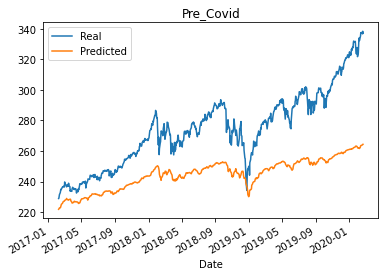

In [192]:
# Plot the real vs predicted prices as a line chart
#PRECOVID
stocks_precovid.plot(title = 'Pre_Covid')

<AxesSubplot:title={'center':'Covid'}, xlabel='Date'>

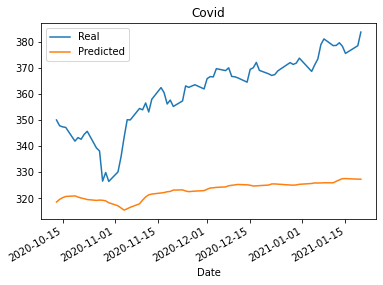

In [193]:
# Plot the real vs predicted prices as a line chart
#COVID
stocks_covid.plot(title = 'Covid')

<AxesSubplot:title={'center':'Covid'}, xlabel='Date'>

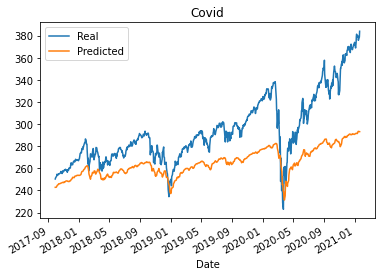

In [220]:
# Plot the real vs predicted prices as a line chart
# DF
stocks_df.plot(title = 'Covid')